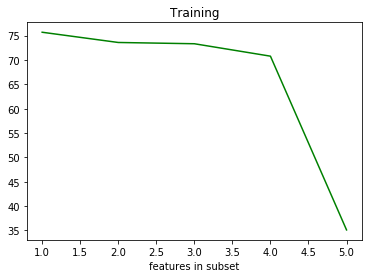

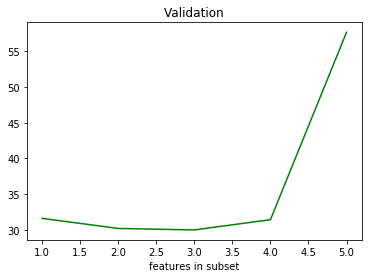

In [4]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import math as math
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

def shapeY(y):
    return np.array(y).reshape(len(y), 1)

# part A
def coef(x):
    return [x**0, x**1, x**2, x**3]

x = [0, 5, 8, 12]
xCoef = np.array(list(map(coef, x)))
y = np.array([10, 5, 12, 0]).reshape(4, 1)
reg = LinearRegression().fit(xCoef, y)

def predict3rdOrder(x):
    return reg.predict(np.array([coef(x)]))[0][0]

# part B
curvePlotX = np.linspace(-5, 20, 50)
curvePlotY = shapeY(list(map(predict3rdOrder, curvePlotX)))

# plt.plot(curvePlotX, curvePlotY, c='red')
# plt.scatter(x, y, c='black')
# plt.axis([-5, 20, -5, 20])
# plt.show()

# part D
uniformRand = np.sort(np.random.uniform(0, 15, 30))
uniformPredicted = shapeY(list(map(predict3rdOrder, uniformRand)))
normal = np.random.normal(0, 10, 30).reshape(30, 1)
withNoise = uniformPredicted + normal

# plt.plot(uniformRand, uniformPredicted, c='red')
# plt.scatter(uniformRand, withNoise, c='black')
# plt.show()

# part E
a0Values = np.linspace(10, 20, 100)
# regMeanSquared = LinearRegression().fit(np.repeat(1, 4).reshape(4, 1), y)

#MSE E
curvePlotX = np.linspace(-10, 20, 100)
#print(curvePlotX)
curvePlotY = np.random.normal(0, 10, 30)

residual = [] * 100

res = 0
for i in range(len(curvePlotX)):
    for y in curvePlotY:
        res += (curvePlotX[i]-y)**2
    residual.append(res/100)
    res = 0

# print(residual)
# plt.plot(curvePlotX, residual, c = 'red')
# plt.show()

#STLF
curvePlotX = np.linspace(-10, 20, 100)
#print(curvePlotX)
curvePlotY = np.random.normal(0, 10, 30)

residual = [] * 100

res = 0
for i in range(len(curvePlotX)):
    for y in curvePlotY:
        if curvePlotX[i]-y < 0:
            #-1/5res
            res += 1/(abs(curvePlotX[i]-5)+0.01) * ((-1/5) * (curvePlotX[i]-y))
        else:
            #10res
            res += 1/(abs(curvePlotX[i]-5)+0.01) * (10 * (curvePlotX[i]-y))
    residual.append(res)
    res = 0

#print(residual)
#plt.plot(curvePlotX, residual, c = 'red')
#plt.show()

# question 2

# part A
f = pd.read_csv("housingdata.csv")

def get(k):
    return lambda a: a[k]

def get_column(n):
    return list(map(get(n), f.values))

def getData(e):
    return (e[1], get_column(e[0]))

columns = dict(map(getData, enumerate(f.columns[:-1])))
MEDV = get_column(13)

def plotMEDV(entry):
    plt.title(entry[0])
    plt.xlabel(entry[0])
    plt.ylabel('MEDV')
    plt.scatter(entry[1], MEDV)
    plt.show()

# for e in columns.items():
#     plotMEDV(e)

# part B

def flatten(l):
    return [item for sublist in l for item in sublist]


subsetKeys = ['AGE', 'INDUS', 'NOX', 'RM', 'TAX']

allSubsets = flatten(map(lambda n: it.combinations(subsetKeys, n), range(len(subsetKeys) + 1)[1:]))
MEDVTrain = shapeY(np.array(MEDV[:400]))
MEDVValid = shapeY(MEDV[400:])
columnsTrain = dict(map(lambda e: (e[0], e[1][:400]), columns.items()))
columnsValid = dict(map(lambda e: (e[0], e[1][400:]), columns.items()))

def getSubset(columns, subs):
    return np.array(list(map(lambda k: columns[k], subs))).transpose()

def subsetModel(subs):
    reg = LinearRegression()
    trainSubset = getSubset(columnsTrain, subs)
    validSubset = getSubset(columnsValid, subs)
    reg.fit(trainSubset, MEDVTrain)
    return {
        # 'model': reg,
        'subs': subs,
        'mseValid': mean_squared_error(reg.predict(validSubset), MEDVValid),
        'mseTrain': mean_squared_error(reg.predict(trainSubset), MEDVTrain)
    }

subsetErrors = list(map(subsetModel, allSubsets))
subsetErrors.sort(key=get('mseValid'))
# print('The best subset is ' + str(subsetErrors[0]['subs']) + ' with a mean squared error of ' + str(subsetErrors[0]['mseValid']))

# part C

def bestSubsetOfSize(n):
    return list(filter(lambda e: len(e['subs']) == n, subsetErrors))[0]

bestSubsets = list(map(bestSubsetOfSize, range(1, 6)))
# for i in range(5):
#     print('Best subset of size ' + str(i + 1) + ' is ' + str(bestSubsets[i]['subs']) + ' with MSE ' + str(bestSubsets[i]['mseValid']))

# ii
subsetErrorX = range(1, len(bestSubsets) + 1)
subsetErrorValid = list(map(get('mseValid'), bestSubsets))
subsetErrorTrain = list(map(get('mseTrain'), bestSubsets))

plt.title('Training')
plt.xlabel('features in subset')
plt.plot(subsetErrorX, subsetErrorTrain, color = 'green')
plt.show()

plt.title('Validation')
plt.plot(subsetErrorX, subsetErrorValid, color = 'green')
plt.xlabel('features in subset')
plt.show()

# iii
largestSubset = getSubset(columns, subsetKeys)
largestSubsetReg = LinearRegression().fit(largestSubset, MEDV)
largestSubsetError = mean_squared_error(largestSubsetReg.predict(largestSubset), MEDV)

def penalties(subs):
    reg = LinearRegression()
    x = getSubset(columns, subs)
    reg.fit(x, MEDV)
    return {
        'subs': subs,
        'penalty': mean_squared_error(reg.predict(x), MEDV) + (2 * len(subs) * largestSubsetError / len(x))
    }

allPenalties = list(map(penalties, allSubsets))
allPenalties.sort(key=get('penalty'))

def leastPenaltyOfSize(n):
    return list(filter(lambda e: len(e['subs']) == n, allPenalties))[0]

bestPenalties = list(map(leastPenaltyOfSize, range(1, 6)))
penaltyPlotX = range(1, len(bestPenalties) + 1)
penaltyPlotY = list(map(get('penalty'), bestPenalties))

# plt.title('Mallows Penalties')
# plt.plot(penaltyPlotX, penaltyPlotY)
# plt.show()

# iv
allData = np.array(list(columns.values())).transpose()
largestSubsetTrain = largestSubset[:400]
largestSubsetValid = largestSubset[400:]

L2Norm = lambda coll: math.sqrt(sum(map(lambda x: x*x, coll)))
newRidge = lambda alpha: Ridge(alpha=alpha, normalize=True)
newLasso = lambda alpha: Lasso(alpha=alpha, normalize=True)
getCoefRidge = lambda model: model.coef_[0]
getCoefLasso = lambda model: model.coef_

def modelComplexity(model, getCoef, alpha):
    m = model(alpha)
    m.fit(largestSubsetTrain, MEDVTrain)
    L2 = L2Norm(getCoef(m))
    return {
        'model' : m,
        'alpha': alpha,
        'complexity': mean_squared_error(m.predict(largestSubsetValid), MEDVValid) + L2 * alpha
    }

alphas = list(np.linspace(0.005, 0.5, 200))
# totalComplexity0 = modelComplexity(newLasso, getCoefLasso, 0)

# allComplexities = map(lambda alpha: modelComplexity(newLasso, getCoefLasso, alpha), alphas)
# totalComplexities = list(allComplexities)

# for c in allComplexities:
#     if(c['complexity'] >= totalComplexity0['complexity']):
#         break
#     totalComplexities.append(c)

# totalComplexitiesSorted = list(map(lambda x: x, totalComplexities))
# totalComplexitiesSorted.sort(key=lambda c: c['complexity'])
# totalComplexityValues = list(map(lambda c: c['complexity'], totalComplexities))
# totalComplexityAlphas = list(map(lambda c: c['alpha'], totalComplexities))
# plt.plot(shapeY(totalComplexityAlphas), shapeY(totalComplexityValues))
# plt.show()

# 2_d_1

allKeys = frozenset(columns.keys())
allSubsets1 = [list([x]) for x in allKeys]

levels = dict()
levels[1] = dict([(frozenset(subs), subsetModel(subs)) for subs in allSubsets1])

def conj(coll, x):
    c = copy.copy(coll)
    c.append(x)
    return c

def addLevel(n):
    if(n - 1 not in levels):
        return
    for (subs, error) in levels[n - 1].items():
        levels[n] = dict()
        restKeys = allKeys - subs
        addedKey = frozenset([frozenset(conj([s for s in subs], k)) for k in restKeys])
        # add errors for all subsets of size n + 1
        for s in addedKey:
            if(s in levels[n]):
                continue
            nextError = subsetModel(s)
            if(nextError['mseValid'] < error['mseValid']):
                levels[n][s] = nextError

for i in range(2, 8):
    addLevel(i)

# last level shouldnt be empty
if(len(levels[len(levels)]) == 0):
    levels.pop(len(levels))

def bestInLevelByTrain(l):
    v = list(l.values());
    v.sort(key=lambda e: e['mseTrain'])
    return v

def bestInLevelByValid(l):
    v = list(l.values());
    v.sort(key=lambda e: e['mseValid'])
    return v

# 2_d_1_1
bestInLevelsByTrain = [l[0]['mseTrain'] for l in map(bestInLevelByTrain, levels.values())]
# plt.plot(shapeY(range(1, len(bestInLevelsByTrain) + 1)), shapeY(bestInLevelsByTrain), color = 'green')
# plt.title('Forward Search of training set')
# plt.xlabel('# of Features')
# plt.show()

# 2_d_1_2 and 2_d_1_3
allLevelsSortedByValid = [value for level in levels.values() for value in level.values()]
allLevelsSortedByValid.sort(key=lambda e: e['mseValid'])
bbv = allLevelsSortedByValid[0]
bestInLevelsByValid = [l[0]['mseValid'] for l in map(bestInLevelByValid, levels.values())]
# plt.plot(shapeY(range(1, len(bestInLevelsByValid) + 1)), shapeY(bestInLevelsByValid), color = 'green')
# plt.title('Forward Search of validation set')
# plt.xlabel('# of Features')
# plt.show()
# print('Best model by validation data is ' + str(tuple(bbv['subs'])) + ' with mse ' + str(bbv['mseValid']))



# 2_d_2
levels = dict()

levels[13] = dict([(frozenset(allKeys), subsetModel(allKeys))])

def disj(coll, x):
    return [e for e in coll if e != x]

def backLevel(n):
    if(n + 1 not in levels):
        return
    levels[n] = dict()
    for (subs, error) in levels[n + 1].items():
        removedKey = [frozenset(disj(subs, k)) for k in subs]
        for s in removedKey:
            if(s in levels[n]):
                continue
            nextError = subsetModel(s)
            if(nextError['mseValid'] < error['mseValid']):
                levels[n][s] = nextError

for i in range(13, 1, -1):
    backLevel(i)

# first level shouldnt be empty
bottomLevelKey = list(levels.keys())[0]
if(len(levels[bottomLevelKey]) == 0):
    levels.pop(bottomLevelKey)


# 2_d_2_1
bestInLevelsByTrain = [l[0]['mseTrain'] for l in map(bestInLevelByTrain, levels.values())]
# plt.plot(shapeY(range(1, len(bestInLevelsByTrain) + 1)), shapeY(bestInLevelsByTrain), color = 'green')
# plt.title('Backward Search of training set')
# plt.xlabel('# of Features')
# plt.show()

# 2_d_2_2 and 2_d_2_3
allLevelsSortedByValid = [value for level in levels.values() for value in level.values()]
allLevelsSortedByValid.sort(key=lambda e: e['mseValid'])
bbv = allLevelsSortedByValid[0]
bestInLevelsByValid = [l[0]['mseValid'] for l in map(bestInLevelByValid, levels.values())]
#plt.plot(shapeY(range(1, len(bestInLevelsByValid) + 1)), shapeY(bestInLevelsByValid), color = 'green')
#plt.title('Backward Search of validation set')
#plt.xlabel('# of Features')
#plt.show()


#('Best model by validation data is ' + str(tuple(bbv['subs'])) + ' with mse ' + str(bbv['mseValid']))
